## Solar Panel Fault Identification 
### Task Model
Applied Machine Learning Project <br>

Solar Panel Fault Detection using CNN

**Task description and objectives**
- The aim of this project is to create a Machine Learning Model that accurately predicts and shows what type of defect a solar panel has, based on pictures of it.
- It will be a supervised learning model. 
- Supervised: Predict type or presence of defect (classification) based on image data.

### Data fetching and libraries

In [1]:
# Local changes needed for better visualisation of outputs 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # hides INFO and WARNING logs|

from IPython.display import HTML

HTML('''
<style>
/* for JupyterLab: limit each output pane to 400px tall and add a scrollbar */
.jp-OutputArea-child {
  max-height: 400px;
  overflow-y: auto;
}

/* for classic Jupyter: same idea */
.output_scroll {
  max-height: 400px;
  overflow-y: auto;
}
</style>
''')

In [ ]:
# Libraries used throughout this script
import opendatasets as od

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

2025-05-27 17:26:23.649632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 17:26:24.213866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748359584.414570   22248 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748359584.473076   22248 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748359584.912489   22248 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# GPU configuration (run in a notebook cell)
print("Built with CUDA:", tf.test.is_built_with_cuda())

build_info = tf.sysconfig.get_build_info()
print("CUDA version (build):", build_info.get("cuda_version"))
print("cuDNN version (build):", build_info.get("cudnn_version"))

gpus = tf.config.list_physical_devices("GPU")
print("GPUs visible to TF:", gpus)

Built with CUDA: True
CUDA version (build): 12.5.1
cuDNN version (build): 9
GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
od.download('https://www.kaggle.com/datasets/pythonafroz/solar-panel-images') # use force=True for forcing the download
data_dir = './solar-panel-images/Faulty_solar_panel'

Skipping, found downloaded files in "./solar-panel-images" (use force=True to force download)


### Data preprocessing

In [4]:
# Data parameters
img_size = (244, 244)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Point at your (possibly modified) images folder
data_root = Path(data_dir)

# Rebuild the list of all image paths *after* you deleted the bad ones
all_paths  = sorted(data_root.rglob("*.jpg"))
all_labels = [p.parent.name for p in all_paths]
class_names = sorted([p.name for p in data_root.iterdir() if p.is_dir()])
print("Classes:", class_names)

Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage']


In [5]:
# Train/Val/Test splits (80/20 → then 80/16/4 split)
paths_trainval, paths_test, labels_trainval, labels_test = train_test_split(
    all_paths, all_labels,
    test_size=0.20,
    stratify=all_labels,
    random_state=123
)

paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_trainval, labels_trainval,
    test_size=0.20,
    stratify=labels_trainval,
    random_state=123
)

# Utility funcs to load & resize (raw, unbatched)
def make_ds(paths, labels):
    path_ds  = tf.data.Dataset.from_tensor_slices([str(p) for p in paths])
    label_to_index = {name:i for i,name in enumerate(class_names)}
    label_ds = tf.data.Dataset.from_tensor_slices([label_to_index[l] for l in labels])
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    def load_and_resize(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, label
    return ds.map(load_and_resize, num_parallel_calls=AUTOTUNE)

# Build raw (unbatched) datasets
raw_train_ds = make_ds(paths_train, labels_train)
raw_val_ds   = make_ds(paths_val,   labels_val)
raw_test_ds  = make_ds(paths_test, labels_test)

# Augmentation & preprocess functions
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augment(image)
    return image, label

def preprocess_val(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build final pipelines: shuffle/augment/batch/prefetch
train_ds = (raw_train_ds
    .map(preprocess_train, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
val_ds = (raw_val_ds
    .map(preprocess_val, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
test_ds = (raw_test_ds
    .map(preprocess_val, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Print approximate dataset sizes
print("Train samples (approx):", tf.data.experimental.cardinality(train_ds).numpy() * batch_size)
print("Val   samples (approx):", tf.data.experimental.cardinality(val_ds).numpy()   * batch_size)
print("Test  samples (approx):", tf.data.experimental.cardinality(test_ds).numpy()  * batch_size)

I0000 00:00:1748359606.633911   22248 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:64:00.0, compute capability: 8.9


Train samples (approx): 448
Val   samples (approx): 128
Test  samples (approx): 160


### LeNet Model

In [6]:
# Model definition LeNet
# ----------------
# Build a simple CNN using Keras Sequential API. Adjust the number of filters,
# kernel sizes, and dense units as needed for your solar-panel defect task.
num_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),    # input layer
    layers.Conv2D(8, kernel_size=5, activation='relu'),  # conv block 1
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(16, kernel_size=5, activation='relu'), # conv block 2
    layers.MaxPooling2D(pool_size=2),
    layers.GlobalAveragePooling2D(),                     # global pooling
    layers.Dense(128, activation='relu'),                # fully connected
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)                            # logits output
])

model.summary()  # prints model architecture and parameter counts

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 240, 240, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 116, 16)   │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,581 (56.96 KB)

 Trainable params: 14,581 (56.96 KB)

 Non-trainable params: 0 (0.00 B)

### AlexNet Model

In [8]:
# Model definition
# ----------------
# Build a simple CNN using Keras Sequential API. Adjust the number of filters,
# kernel sizes, and dense units as needed for your solar-panel defect task.
num_classes = len(class_names)

model_AlexNet = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),    # input layer
    layers.Conv2D(64, kernel_size=11, activation='relu'),  # conv block 1
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(128, kernel_size=5, activation='relu'),   # conv block 2
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=3),                     # global pooling
    layers.Flatten(),
    layers.Dense(512, activation='relu'),                # fully connected
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')      # logits output
])

model_AlexNet.summary()  # prints model architecture and parameter counts|

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 234, 234, 64)   │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 74, 74, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,688,390 (25.51 MB)

 Trainable params: 6,688,390 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

### Alt model

In [15]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Input((244,244,3)),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.summary()  # prints model architecture and parameter counts

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 242, 242, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 121, 121, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 119, 119, 256)  │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 59, 59, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,342 (649.77 KB)

 Trainable params: 166,342 (649.77 KB)

 Non-trainable params: 0 (0.00 B)

### MobileNet

In [ ]:
num_classes = len(class_names)
print(f"Number of classes: {num_classes}\n")

# Model definition
model = models.Sequential([
    layers.Input((244,244,3)),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.summary()  # prints model architecture and parameter counts

### Model training

In [7]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [9]:
# Compile & train
# ----------------
# Configure the training process: optimizer, loss function, and metrics.
# Then fit the model on `train_ds`, validating on `val_ds`.
epochs = 100

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=64,
    epochs=epochs
)

Epoch 1/100


11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.5625 - sparse_categorical_accuracy: 0.2531

2025-05-27 17:27:37.819272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_343', 12 bytes spill stores, 12 bytes spill loads

2025-05-27 17:27:38.112867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_343', 4 bytes spill stores, 4 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 3.6979 - sparse_categorical_accuracy: 0.2607 - val_loss: 4.0043 - val_sparse_categorical_accuracy: 0.2613
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 4.0683 - sparse_categorical_accuracy: 0.2866 - val_loss: 3.9061 - val_sparse_categorical_accuracy: 0.3153
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 3.7667 - sparse_categorical_accuracy: 0.3037 - val_loss: 4.0456 - val_sparse_categorical_accuracy: 0.3333
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 4.1702 - sparse_categorical_accuracy: 0.2137 - val_loss: 4.2303 - val_sparse_categorical_accuracy: 0.2432
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 3.9333 - sparse_categorical_accuracy: 0.2647 - val_loss: 4.0981 - val_sparse_categorical_accuracy: 0.2342
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 3.9854 - sparse_categorical_accuracy: 0.2777 - val_loss: 4.0922 - val_sparse_categorical_accuracy: 0.2342
Epoch 7/100
14

### Model evaluation

In [10]:
# Final evaluation on test set
# --------------------------------------------
# Compute loss & accuracy on the held-out test set
# (this data was never used during training or validation)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test         → Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step - loss: 1.6094 - sparse_categorical_accuracy: 0.2313
Test         → Loss: 1.6094, Accuracy: 0.2446


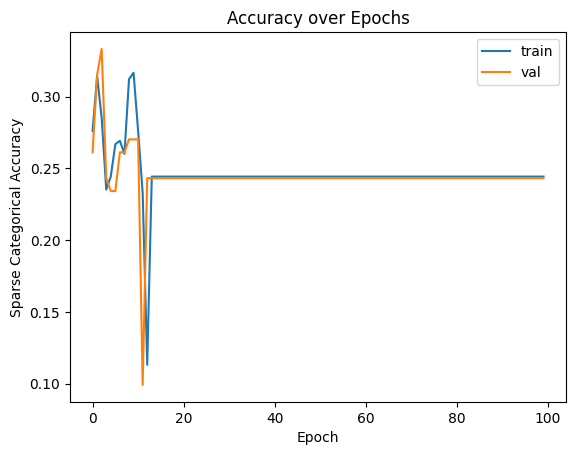

In [11]:
# Plot training & validation accuracy
# ------------------------------------
# Visualize how accuracy evolves over epochs to spot overfitting/underfitting.
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend()
plt.show()

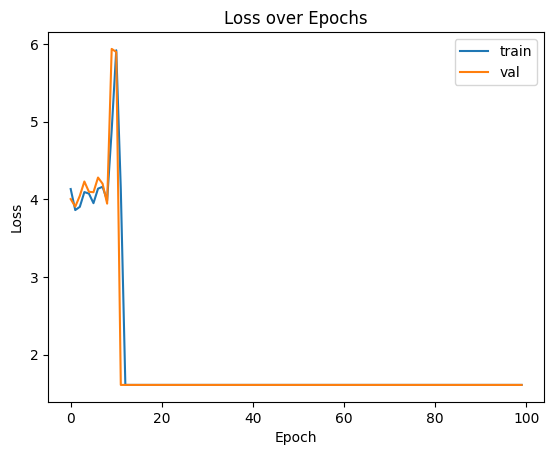

In [12]:
# Plot training & validation loss
# --------------------------------
# Show loss curves for train vs. validation to assess convergence.
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


2025-05-27 17:37:17.774636: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


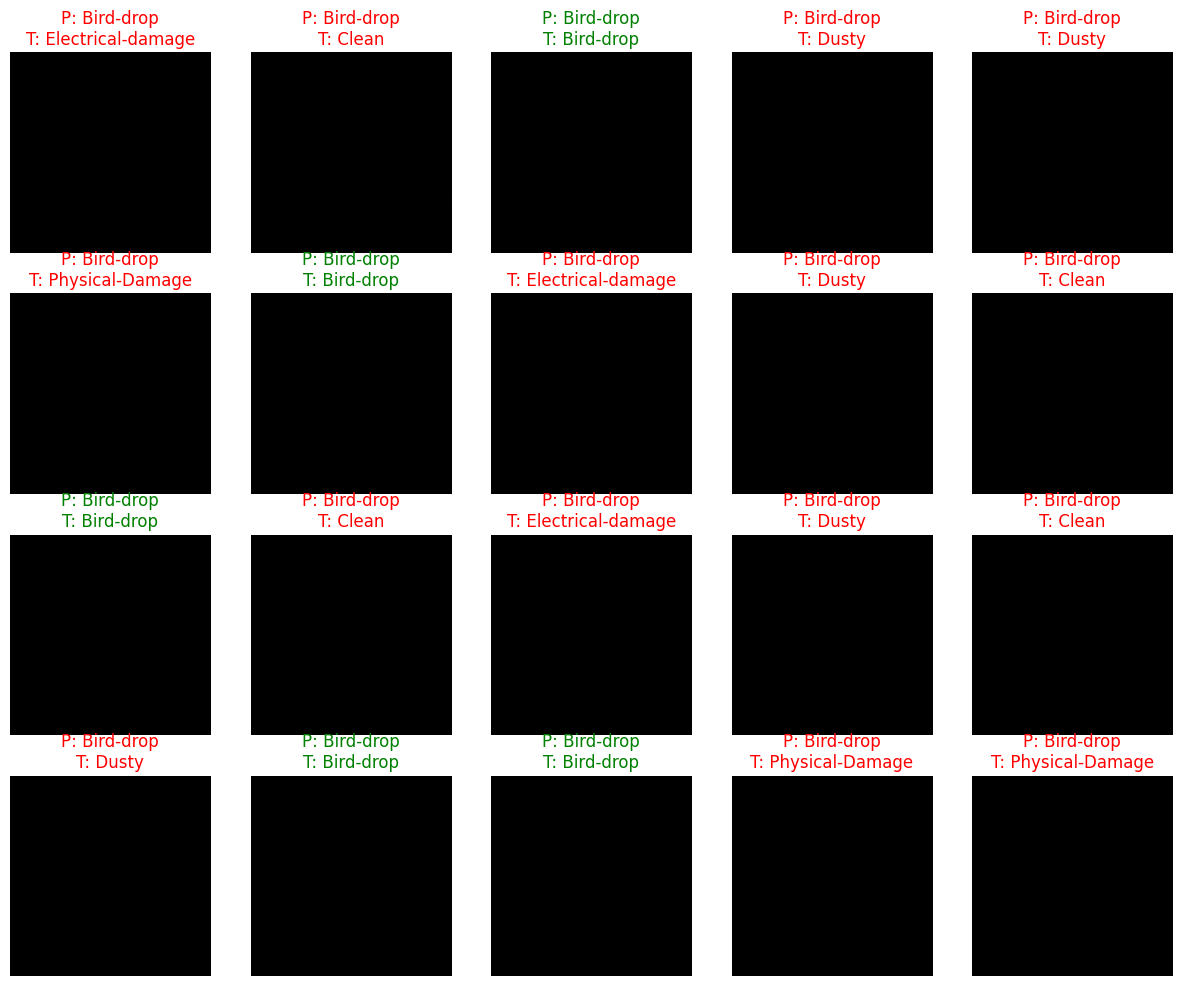

In [13]:
# Visualize sample predictions
# ----------------------------
# Take one batch from val_ds, run predictions, and display a 4×5 grid of images
# with predicted vs. true labels colored green (correct) or red (incorrect).
plt.figure(figsize=(15, 12))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for i in range(min(20, images.shape[0])):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        color = 'green' if pred_labels[i] == labels[i] else 'red'
        plt.title(f"P: {class_names[pred_labels[i]]}\nT: {class_names[labels[i]]}", color=color)
        plt.axis('off')
plt.show()